## [Fitting a Bayesian Factor Analysis Model in Stan](https://rfarouni.github.io/assets/projects/BayesianFactorAnalysis/BayesianFactorAnalysis.html)

### [Cholesky factors of covariance matrices](https://mc-stan.org/docs/reference-manual/cholesky-factors-of-covariance-matrices-1.html)

### [Cholesky factors of covariance and correlation matrices in Stan](https://yingqijing.medium.com/cholesky-factors-of-covariance-and-correlation-matrices-in-stan-37a302d11690)

A Cholesky factor of a covariance matrix requires $N + (N/2) + (M−N)N$ unconstrained parameters.

$$y^T=(y_1,y_2, ..., y_p)$$
$$y=\Lambda \theta + \epsilon$$

$$\Lambda=
\begin{bmatrix}
\lambda_{1,1} & \lambda_{1,2} & \dots & \lambda_{1,D}\\
\lambda_{2,1} & \lambda_{2,2} & \dots & \lambda_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\lambda_{p,1} & \lambda_{p,2} & \dots & \lambda_{p,D}\\
\end{bmatrix}$$

$$\Phi_D = 
\begin{bmatrix}
1 & \varphi_{1,2} & \dots & \varphi_{1,D}\\
\varphi_{2,1} & 1 & \dots & \varphi_{2,D}\\
\vdots & \vdots & \vdots & \vdots\\
\varphi_{D,1} & \dots &\varphi_{D,D-1} & 1\\
\end{bmatrix}$$

$$\Psi_P = 
\begin{bmatrix}
\psi_1 & 0 & \dots & 0\\
0 & \psi_2 & \dots & 0\\
\vdots & \vdots & \vdots & \vdots\\
0 & \dots &0 & \psi_P\\
\end{bmatrix}$$

$$y\sim Normaal_P(0, \Lambda\Phi\Lambda^T+\Psi)$$

$$p(\Theta,\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N p(y_i|\theta_i,\Lambda)\right] \left[ \prod _{i=1}^{N} p(\theta_i|\Phi) \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

N D-dimensional latent vectors $\Theta=(\theta_1. \theta_2, \dots, theta_i, \dots, \theta_N)$
$$p(\Lambda,\tilde{\xi},\Phi|Y)\propto \left[ \prod _{i=1}^N \int_{R_\theta} p(y_i|\theta_i,\Lambda) p(\theta_i|\Phi) d\theta \right]p(\Lambda|\tilde{\xi})p(\Phi)p(\tilde{\xi})$$

$y_i$ is a P-dimensional vector of responses for respondent i

### orthogonal rotation matrix T, where $T^TT=I$ and $\lambda T^TT\theta=\Lambda\theta$

### Simulating Data

In [ ]:
library(MASS)

In [ ]:
D <- 3
P <- 10
N <- 300

In [ ]:
mu_theta = rep(0, D)
mu_epsilon = rep(0, P)

In [ ]:
Phi <- diag(rep(1,D))
Psi <- diag(c(0.2079, 0.19, 0.1525, 0.20, 0.36, 0.1875, 0.1875, 1.00, 0.27, 0.27))

In [ ]:
l1 <- c(0.99, 0.00, 0.25, 0.00, 0.80, 0.00, 0.50, 0.00, 0.00, 0.00)
l2 <- c(0.00, 0.90, 0.25, 0.40, 0.00, 0.50, 0.00, 0.00, -0.30, -0.30)
l3<-  c(0.00, 0.00, 0.85, 0.80, 0.00, 0.75, 0.75, 0.00, 0.80, 0.80)
L = cbind(l1,l2,l3)

In [ ]:
Theta <- mvrnorm(N, mu_theta, Phi)

In [ ]:
Epsilon <- mvrnorm(N, mu_epsilon, Psi)

In [ ]:
Y <- Theta %*% t(L) + Epsilon

In [ ]:
dim(Y)

In [ ]:
dl_fa <- list(
    N = N,
    P = P,
    D = D,
    Y = Y
)

In [ ]:
saveRDS(dl_fa, file = 'factor_data_list.rds')

### Visualization

In [ ]:
library(rbokeh)

In [ ]:
df <- data.frame(Y)

In [ ]:
names(df)[1:P]

In [ ]:
tools <- c("pan", "wheel_zoom", "resize", "reset")

In [ ]:
nms <- expand.grid(names(df)[1:P], rev(names(df)[1:P]), stringsAsFactors = FALSE)

In [ ]:
nms$Var2[1]

In [ ]:
nms$yaxis <- rep(c(TRUE, rep(FALSE, P-1)), P)
nms$xaxis <- c(rep(FALSE, (P-1)*P), rep(TRUE, P))

In [ ]:
nms$h <- nms$w <- 75
nms$h[nms$xaxis] <- nms$w[nms$yaxis] <- 90

In [ ]:
library(ggplot2)
library(gridExtra)

In [ ]:
plot_uni_scatter <- function(df, nms, i){
    return( ggplot(data = df, aes(x = get(nms$Var1[i]), y = get(nms$Var2[i]))) + geom_point(color='blue') +
    xlab(nms$Var1[i]) + ylab(nms$Var2[i]) + theme(axis.text = element_text(size=2), axis.title = element_text(size=3)) )
}

In [ ]:
plot_uni_scatter(df, nms, 2)

In [ ]:
plot_list <- vector('list', P^2)

In [ ]:
for (i in seq_along(plot_list)){
    #message(i)
    p <-ggplotGrob(plot_uni_scatter(df, nms, i))
    plot_list[[i]] <- p
}

In [ ]:
grid.arrange(grobs = plot_list, ncol = 10)

## Estimation

In [ ]:
library(dplyr)
library(rstan)
library(bayesplot)
library(Metrics)
library(pracma)
options(mc.cores = parallel::detectCores())
rstan_options(auto_write = TRUE)

In [ ]:
remove(model)
model = stan_model('../RStan/Models/factor_mvn.stan')

In [ ]:
remove(fit)
fit <- sampling(object = model,
                data = dl_fa,
                init = "random",
                control = list(adapt_delta = 0.95),
                chains = 4,
                iter = 888,
                warmup = 555,
                thin = 1,
                verbose = TRUE)

## Posterior Analysis

In [ ]:
summary(fit)

In [ ]:
names(fit)

In [ ]:
traceplot(fit, pars=c("L_d"))

In [ ]:
theme_Posterior = theme(
  axis.line.x = element_line(arrow=arrow(length=unit(0.05, "cm")), lineend = "butt"),
  panel.background = element_rect(fill="transparent"), 
  panel.border = element_rect(fill="transparent"),
  plot.background = element_rect(fill = "transparent"),
  #panel.spacing.y = unit(1,"lines"),
  plot.margin = unit(c(1,1,1,1), "cm"), 
  #
  axis.title.y = element_blank(), 
  axis.text.y = element_text(color = "grey20", size = 8, angle = 0, hjust = 1, vjust = 0, face = "plain"),
  axis.text.x = element_text(color="grey20",hjust=1, vjust=1, size=8, angle=50, face="plain"), 
  axis.ticks.y = element_blank()
)

In [ ]:
plot(fit,
     pars = names(fit)[c(1:24)],
     show_density = FALSE,
     fill_color = "#998811",
     est_color = "#ffffff",
     ci_level = 0.9, outer_level=0.95) +
  geom_vline(xintercept = 0, linetype = 3, linewidth = 0.5) + 
  theme_Posterior

ci_level: 0.9 (90% intervals)

outer_level: 0.95 (95% intervals)



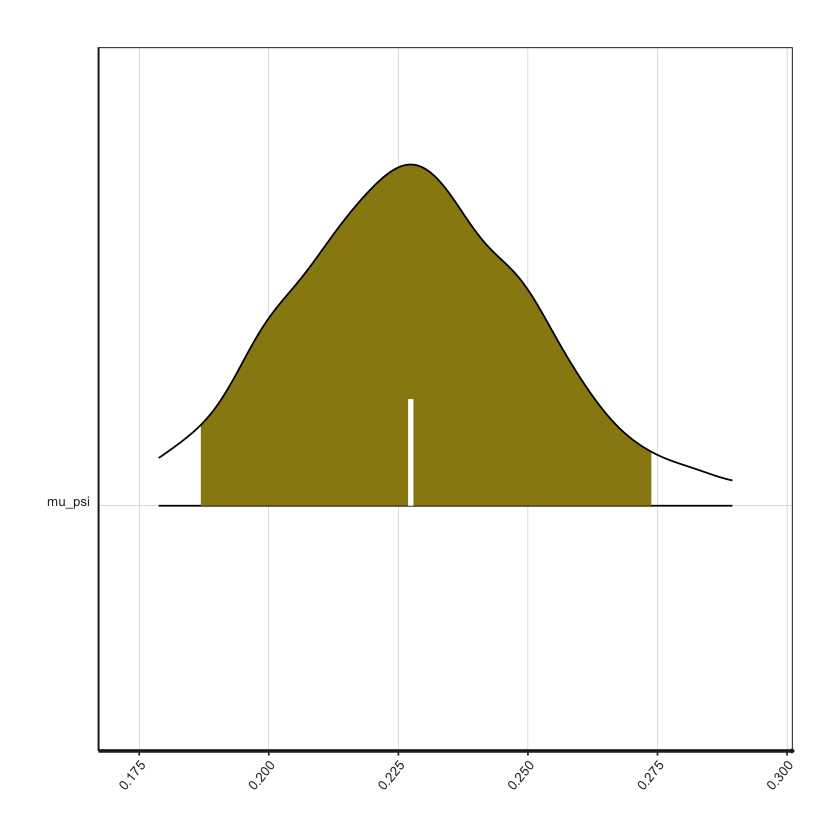

In [39]:
plot(fit,
     pars = c("mu_psi"),
     show_density = TRUE,
     fill_color = "#998811",
     est_color = "#ffffff",
     ci_level = 0.9, outer_level=0.95) +
  #geom_vline(xintercept = 0, linetype = 3, linewidth = 0.5) + 
  theme_Posterior

ci_level: 0.9 (90% intervals)

outer_level: 0.95 (95% intervals)



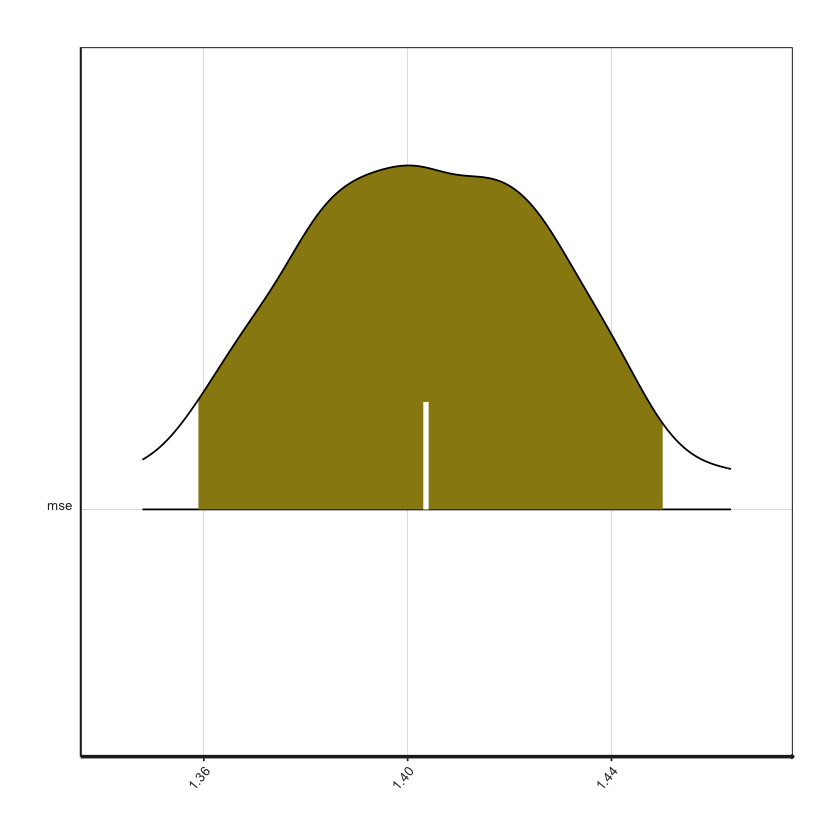

In [40]:
plot(fit,
     pars = c("mse"),
     show_density = TRUE,
     fill_color = "#998811",
     est_color = "#ffffff",
     ci_level = 0.9, outer_level=0.95) +
  #geom_vline(xintercept = 0, linetype = 3, linewidth = 0.5) + 
  theme_Posterior

In [42]:
color_scheme_set('viridisA')
bayesplot_theme_set(theme_classic())

draws = extract(fit)
y = dl_fa$Y
str(y)
yrep = draws$yp
str(yrep)

y =as.vector(Reshape(y, 1))
yrep = Reshape(yrep, 1332)

ncol(yrep)
length(y)

 num [1:300, 1:10] -0.137 0.503 0.719 0.224 1.547 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : NULL
 num [1:1332, 1:300, 1:10] 0.301 0.93 2.027 -0.086 0.382 ...
 - attr(*, "dimnames")=List of 3
  ..$ iterations: NULL
  ..$           : NULL
  ..$           : NULL


[1] 3000

[1] 3000

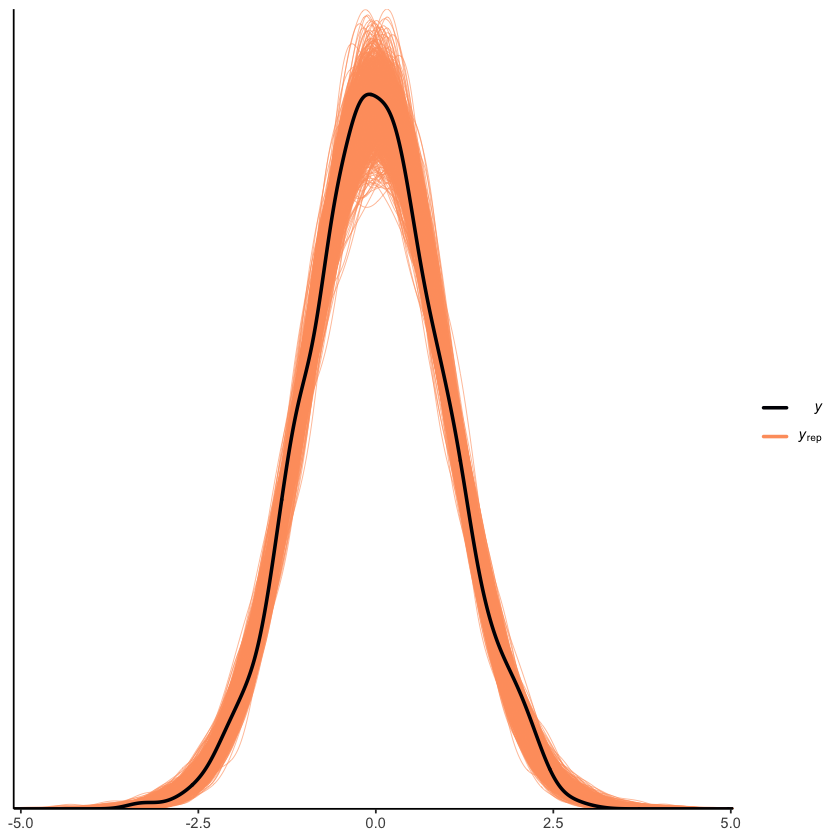

In [43]:
ppc_dens_overlay(y=y, yrep = yrep)

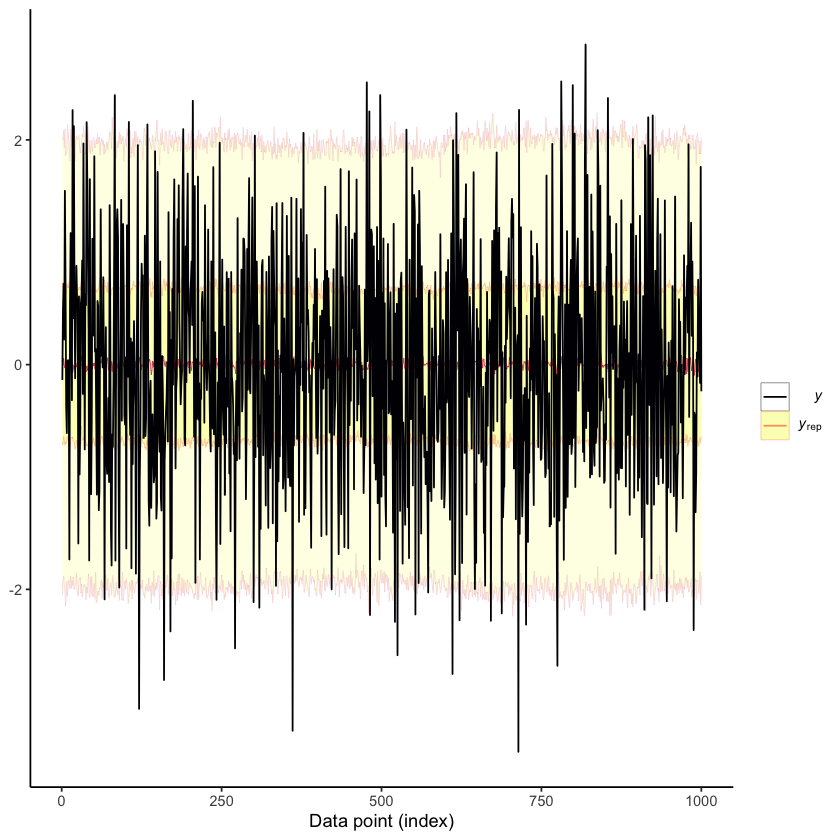

In [44]:
ppc_ribbon(y[1:1000], yrep[,1:1000], prob_outer = 0.95, prob = 0.5, alpha = 0.4)

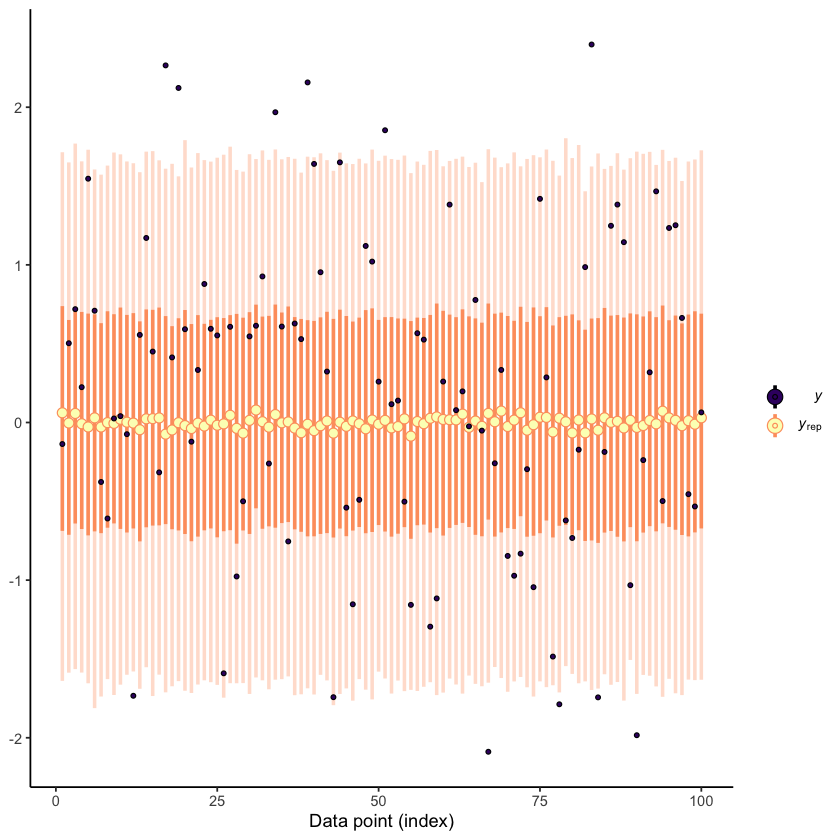

In [46]:
ppc_intervals(y[1:100], yrep[,1:100], linewidth = 1)

In [47]:
mses = c()
for (i in 1:dim(yrep)[1]){
    mses<-c(mses, mse(y, yrep[i,]))
  }
rmse = sqrt(mean(mses))
rmse

[1] 1.404429